# 生存分析
## 生存曲线与危险函数
生存曲线(survival curve) S(t)是一个函数，将一个持续时间t映射到存活时间超过t的概率。如果已知持续时间（或“生存期”）的分布，那么就很容易计算出生存曲线，即CDF的补函数。

S(t)=1-CDF(t)

从生存函数可以推导出危险函数(hazard function)。妊娠持续时间的危险函数从时间t映射到t终止的妊娠比例：

$\lambda(t)=\frac{S(t)-S(t+1}{S(t)}$

公式中的分子是终止于t的生存期比例，也就是PMF(t)。

In [1]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import pandas
import thinkstats2
import thinkplot
import nsfg

Number of complete pregnancies 11189
Number of ongoing pregnancies 352
0.13978014121
0.86021985879
0.676706827309


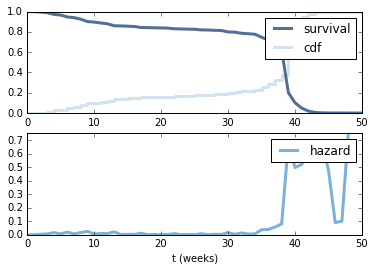

In [2]:
import pandas as pd
from collections import Counter

class SurvivalFunction(object):
    """Represents a survival function."""

    def __init__(self, ts, ss, label=''):
        self.ts = ts
        self.ss = ss
        self.label = label

    def __len__(self):
        return len(self.ts)

    def __getitem__(self, t):
        return self.Prob(t)

    def Prob(self, t):
        """Returns S(t), the probability that corresponds to value t.
        t: time
        returns: float probability
        """
        return np.interp(t, self.ts, self.ss, left=1.0)

    def Probs(self, ts):
        """Gets probabilities for a sequence of values."""
        return np.interp(ts, self.ts, self.ss, left=1.0)

    def Items(self):
        """Sorted list of (t, s) pairs."""
        return zip(self.ts, self.ss)

    def Render(self):
        """Generates a sequence of points suitable for plotting.
        returns: tuple of (sorted times, survival function)
        """
        return self.ts, self.ss

    def MakeHazardFunction(self, label=''):
        """Computes the hazard function.

        This simple version does not take into account the
        spacing between the ts.  If the ts are not equally
        spaced, it is not valid to compare the magnitude of
        the hazard function across different time steps.

        label: string

        returns: HazardFunction object
        """
        lams = pd.Series(index=self.ts)

        prev = 1.0
        for t, s in zip(self.ts, self.ss):
            lams[t] = (prev - s) / prev
            prev = s

        return HazardFunction(lams, label=label)

    def MakePmf(self, filler=None):
        """Makes a PMF of lifetimes.

        filler: value to replace missing values

        returns: Pmf
        """
        cdf = thinkstats2.Cdf(self.ts, 1-self.ss)
        pmf = thinkstats2.Pmf()
        for val, prob in cdf.Items():
            pmf.Set(val, prob)

        cutoff = cdf.ps[-1]
        if filler is not None:
            pmf[filler] = 1-cutoff

        return pmf

    def RemainingLifetime(self, filler=None, func=thinkstats2.Pmf.Mean):
        """Computes remaining lifetime as a function of age.
        func: function from conditional Pmf to expected liftime
        returns: Series that maps from age to remaining lifetime
        """
        pmf = self.MakePmf(filler=filler)
        d = {}
        for t in sorted(pmf.Values())[:-1]:
            pmf[t] = 0
            pmf.Normalize()
            d[t] = func(pmf) - t

        return pd.Series(d)


def MakeSurvivalFromSeq(values, label=''):
    """Makes a survival function based on a complete dataset.

    values: sequence of observed lifespans
    
    returns: SurvivalFunction
    """
    counter = Counter(values)
    ts, freqs = zip(*sorted(counter.items()))
    ts = np.asarray(ts)
    ps = np.cumsum(freqs, dtype=np.float)
    ps /= ps[-1]
    ss = 1 - ps
    return SurvivalFunction(ts, ss, label)


def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return SurvivalFunction(ts, ss, label)

def PlotSurvival(complete):
    """Plots survival and hazard curves.

    complete: list of complete lifetimes
    """
    thinkplot.PrePlot(3, rows=2)

    cdf = thinkstats2.Cdf(complete, label='cdf')
    sf = MakeSurvivalFromCdf(cdf, label='survival')
    print(cdf[13])
    print(sf[13])

    thinkplot.Plot(sf)
    thinkplot.Cdf(cdf, alpha=0.2)
    thinkplot.Config()

    thinkplot.SubPlot(2)
    hf = sf.MakeHazardFunction(label='hazard')
    print(hf[39])
    thinkplot.Plot(hf)
    thinkplot.Config(ylim=[0, 0.75])


class HazardFunction(object):
    """Represents a hazard function."""

    def __init__(self, d, label=''):
        """Initialize the hazard function.

        d: dictionary (or anything that can initialize a series)
        label: string
        """
        self.series = pd.Series(d)
        self.label = label

    def __getitem__(self, t):
        return self.series[t]

    def Render(self):
        """Generates a sequence of points suitable for plotting.

        returns: tuple of (sorted times, hazard function)
        """
        return self.series.index, self.series.values

    def MakeSurvival(self, label=''):
        """Makes the survival function.

        returns: SurvivalFunction
        """
        ts = self.series.index
        ss = (1 - self.series).cumprod()
        sf = SurvivalFunction(ts, ss, label=label)
        return sf

    def Extend(self, other):
        """Extends this hazard function by copying the tail from another.
        other: HazardFunction
        """
        last_index = self.series.index[-1] if len(self) else 0
        more = other.series[other.series.index > last_index]
        self.series = pd.concat([self.series, more])

    def Truncate(self, t):
        """Truncates this hazard function at the given value of t.
        t: number
        """
        self.series = self.series[self.series.index < t]
    

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return HazardFunction(lams, label=label)

def PlotPregnancyData(preg):
    """Plots survival and hazard curves based on pregnancy lengths.
    
    preg:


    Outcome codes from http://www.icpsr.umich.edu/nsfg6/Controller?
    displayPage=labelDetails&fileCode=PREG&section=&subSec=8016&srtLabel=611932

    1	LIVE BIRTH	 	9148
    2	INDUCED ABORTION	1862
    3	STILLBIRTH	 	120
    4	MISCARRIAGE	 	1921
    5	ECTOPIC PREGNANCY	190
    6	CURRENT PREGNANCY	352

    """
    complete = preg.query('outcome in [1, 3, 4]').prglngth
    print('Number of complete pregnancies', len(complete))
    ongoing = preg[preg.outcome == 6].prglngth
    print('Number of ongoing pregnancies', len(ongoing))

    PlotSurvival(complete)
    thinkplot.Config(root='survival1',
                   xlabel='t (weeks)')

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()
    return sf

preg = nsfg.ReadFemPreg()
sf1 = PlotPregnancyData(preg)

第一个图展示了妊娠持续时间的CDF及其补函数，即生存函数。第二个图展示了危险函数，图中的曲线在13~26周几乎是平的，说明很少有妊娠在第3到第6个月期间终止。这条曲线在39周附近最为陡峭，39周正好是最常见的妊娠持续时间。

## Kaplan-Meier估计
使用数据估计危险函数，然后将危险函数转换为生存函数。要估计初婚年龄的危险函数，我们需要对每个年龄计算：
- 在这个年龄结婚的女性人数；
- “有危险的”女性人数，其中包括在这个年龄之前未婚的所有女性。

在得到危险函数之后，计算生存函数：超过时间t仍然生存的概率是在t之前的所有时间都生存并且在t也生存的概率，即危险补函数的累积乘积：

$[1-\lambda(0)][1-\lambda(1)]...[1-\lambda(t)]$

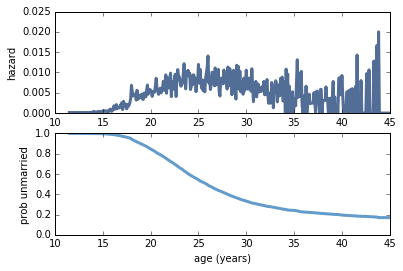

In [4]:
def ReadFemResp(dct_file='2002FemResp.dct',
                dat_file='2002FemResp.dat.gz',
                **options):
    """Reads the NSFG respondent data.

    dct_file: string file name
    dat_file: string file name

    returns: DataFrame
    """
    dct = thinkstats2.ReadStataDct(dct_file, encoding='iso-8859-1')
    df = dct.ReadFixedWidth(dat_file, compression='gzip', **options)
    return df

def CleanFemResp(resp):
    """Cleans a respondent DataFrame.

    resp: DataFrame of respondents

    Adds columns: agemarry, age, decade, fives
    """
    resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)

    resp['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
    resp['age'] = (resp.cmintvw - resp.cmbirth) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['year'] = (pd.DatetimeIndex(dates).year - 1900)
    resp['decade'] = resp.year // 10
    resp['fives'] = resp.year // 5

def ReadFemResp2002():
    """Reads respondent data from NSFG Cycle 6.

    returns: DataFrame
    """
    usecols = ['caseid', 'cmmarrhx', 'cmdivorcx', 'cmbirth', 'cmintvw', 
               'evrmarry', 'parity', 'finalwgt']
    df = ReadFemResp(usecols=usecols)
    df['evrmarry'] = (df.evrmarry == 1)
    CleanFemResp(df)
    return df

def EstimateMarriageSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

def PlotMarriageData(resp):
    """Plots hazard and survival functions.

    resp: DataFrame of respondents
    """
    hf, sf = EstimateMarriageSurvival(resp)

    thinkplot.PrePlot(rows=2)
    thinkplot.Plot(hf)
    thinkplot.Config(ylabel='hazard', legend=False)

    thinkplot.SubPlot(2)
    thinkplot.Plot(sf)
    thinkplot.Config(root='survival2',
                   xlabel='age (years)',
                   ylabel='prob unmarried',
                   ylim=[0, 1],
                   legend=False)
    return sf
resp6 = ReadFemResp2002()
sf2 = PlotMarriageData(resp6)

上图展示了计算得到的估计危险函数。危险函数值在青少年时期很低，20多岁时较高，在30多岁时呈下降趋势。在40多岁时再次上升，但这是估计过程造成的结果。随着“有危险”的参与者人数下降，很少的结婚女性人数会产生很大的估计危险值。生存函数会对这种噪音进行平滑处理。

下图生存曲线在25~35岁最为陡峭，这正是大部分女性结婚年龄。在35~45岁，曲线几乎是平直的，说明35岁前没有结婚的女性很可能不会结婚。

## 群组效应
出生于不同时代的女性具有不同的婚姻模式。像这样由出生日期或类似事件定义的组，称为群组(cohort)，各组之间的差异称为群组效应(cohort effect)。

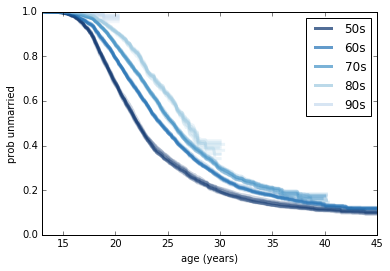

In [7]:
def ReadFemResp1995():
    """Reads respondent data from NSFG Cycle 5.

    returns: DataFrame
    """
    dat_file = '1995FemRespData.dat.gz'
    names = ['cmintvw', 'timesmar', 'cmmarrhx', 'cmbirth', 'finalwgt']
    colspecs = [(12360-1, 12363),
                (4637-1, 4638),
                (11759-1, 11762),
                (14-1, 16),
                (12350-1, 12359)]
    df = pd.read_fwf(dat_file, 
                         compression='gzip', 
                         colspecs=colspecs, 
                         names=names)

    df.timesmar.replace([98, 99], np.nan, inplace=True)
    df['evrmarry'] = (df.timesmar > 0)

    CleanFemResp(df)
    return df

def ReadFemResp2010():
    """Reads respondent data from NSFG Cycle 7.

    returns: DataFrame
    """
    usecols = ['caseid', 'cmmarrhx', 'cmdivorcx', 'cmbirth', 'cmintvw',
               'evrmarry', 'parity', 'wgtq1q16']
    df = ReadFemResp('2006_2010_FemRespSetup.dct',
                       '2006_2010_FemResp.dat.gz',
                        usecols=usecols)
    df['evrmarry'] = (df.evrmarry == 1)
    df['finalwgt'] = df.wgtq1q16
    CleanFemResp(df)
    return df

def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d0s' % name
        thinkplot.Plot([15], [1], label=label, **options)

def EstimateMarriageSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)

def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')

        if omit:
            groups = [(name, group) for name, group in groups 
                      if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)        

def PlotPredictionsByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)
# read Cycles 5 and 7
resp5 = ReadFemResp1995()
resp7 = ReadFemResp2010()

# plot resampled survival functions by decade
resps = [resp5, resp6, resp7]
PlotResampledByDecade(resps)
thinkplot.Config(root='survival4',
               xlabel='age (years)',
               ylabel='prob unmarried',
               xlim=[13, 45],
               ylim=[0, 1])

## 预测剩余生存期

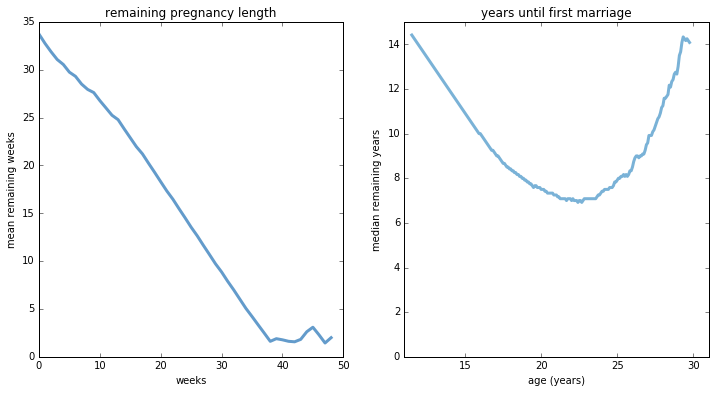

In [8]:
def ResampleSurvival(resp, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """ 
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)

    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1/12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')
    thinkplot.Config(root='survival3',
                   xlabel='age (years)',
                   ylabel='prob unmarried',
                   xlim=[12, 46],
                   ylim=[0, 1])

def PlotRemainingLifetime(sf1, sf2):
    """Plots remaining lifetimes for pregnancy and age at first marriage.

    sf1: SurvivalFunction for pregnancy length
    sf2: SurvivalFunction for age at first marriage
    """
    thinkplot.PrePlot(cols=2)
    rem_life1 = sf1.RemainingLifetime()
    thinkplot.Plot(rem_life1)
    thinkplot.Config(title='remaining pregnancy length',
                     xlabel='weeks',
                     ylabel='mean remaining weeks')

    thinkplot.SubPlot(2)
    func = lambda pmf: pmf.Percentile(50)
    rem_life2 = sf2.RemainingLifetime(filler=np.inf, func=func)
    thinkplot.Plot(rem_life2)
    thinkplot.Config(title='years until first marriage',
                     ylim=[0, 15],
                     xlim=[11, 31],
                     xlabel='age (years)',
                     ylabel='median remaining years')
ResampleSurvival(resp6)
PlotRemainingLifetime(sf1, sf2)

左图展示了以当前妊娠持续时间为参数的预期持续妊娠时间函数：
- 曲线在前3个月缓慢下降。到第13周，预期剩余生存期只下降了9周，达到了25周。之后曲线下降较快，每过1周约下降1周。
- 在第37-42周，曲线走平，值在1~2周。在这一时间段的任何时刻，预期剩余生存期都是相同的，随着每一周的过去，目标却没有更近。具有这种属性的过程称为无记忆的(memoryless)。

右图展示了初婚年龄的剩余时间中位数函数，参数为年龄。
- 对于一个11岁的女孩，到初婚年龄的中位数时间约为14年。这条曲线持续下降，到22岁附近剩余时间中位数保持在7年左右，之后开始上升，到30岁又回到最开始的剩余时间：14年。
- 年轻女性的剩余“生存期”呈下降趋势。具有这一属性的机械组件称为NBUE，即“新比旧好”(new is better than used in expectation)，意思是新部件持续时间更长。
- 超过22岁的女性到初婚的剩余时间呈上升趋势。具有这种属性的组件称为UBNE，即“旧比新好”(used is better than new in expectation)。也就是说，部件越旧，预期持续的时间越长。新生儿和癌症患者也属于UBNE，他们的生存时间越长，预期寿命就越长。
- 对于初婚剩余时间，计算的是中位数而非均值，因为Cdf不是完整的，生存曲线表明，约20%的参与者不会在44岁之前结婚。这些女性的初婚年龄属于未知，有可能并不存在，因此无法计算均值。